# Rockfall localization

## Background

Globally expanding networks of seismic stations are **continuously** measuring ground motion.  
The recorded **seismic signals** constitute a powerful tool to **monitor rockfall activity**, e.g. for:
* event detection,
* event localization,
* volume estimation.

Here, I present you a novel algorithm to track rockfalls [1].  

Idea:  
Using the **high frequency seismic signal** (10-20Hz) to track rockfall with  
**higher spatial and temporal resolution**.

Problem:  
High frequency signals are prone to be **distorted by medium heterogeneities  
and surface topography**.

Approach:  
Model the impulse response from a grid of potential rockfall positions  
using the **Spectral Element Method (SEM)** and localize rockfalls by **combining  
simulations and observations**.

Basic assumption:  
**Spectral ratios** between stations are **characteristic for source position** [2].

## Study site

Dolomieu crater on Piton de la Fournaise volcano, La Réunion. 

![Dolomieu map](images/Dolomieu.png)

## The **S**pectral **E**lement **M**ethod (SEM, [3][4])


Building the numerical domain with:
* Dolomieu crater topography (10m resolution),
* realistic subsurface properties.

<img src="images/SEM_mesh_color.png" alt="Drawing" style="width: 700px;"/>

Then, to simulate the wave field propagation:

![SEM_theory](images/SEM_theory.png)

## Parallelized SEM simulations

As the solution is calculated in each element, it is straightforward to compute the simulations **in parallel**.

![SEM](images/parallelized_SEM.png)

## Reciprocal SEM simulations

Principle of reciprocity:

<img src="images/reciprocity.png" alt="Drawing" style="width: 400px;"/>

With the reciprocal simulations, we create a database of impulse responses (from a 7Hz Ricker wavelet)  
across the whole crater:

<img src="images/SEM_recip.png" alt="Drawing" style="width: 500px;"/>

This is done for each seismic station (4x) and for each available component (east E, north N, vertical Z).  

→ **10 simulations in total**, 

→ each takes **$\sim\,$460 days CPU time** (10 cores per CPU)

## Exploration of synthetic database
As the localization method is based on energy ratios, the **simulated ground velocity** $v_i$ on component $j$ and at gridpoint $i$ is transformed to a proxy of **seismic energy** as:

$$E_{ij} = \int_d v_i^2(t)\, \mathrm{d}t$$

Note that the measurements are filtered at 13-17Hz.

The databse of simulated seismic energy values is stored in `data/simu/`.  
*Let's have a look!*

In [3]:
# Adjust notebook style
from IPython.core.display import HTML
css_file = 'style.css'
HTML(open(css_file,'r').read())

In [19]:
%load_ext autoreload
%autoreload 2

%matplotlib inline   
# Import essential libraries
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
from obspy import read, Stream
from obspy.core import UTCDateTime
from matplotlib.dates import num2date
# Import functions from modules subdirectory
from modules.m_PLOTS import *
from modules.m_PickTW import cd, pickTW
from modules.m_PROB import calc_prob
from modules.m_SEdeconv import deconvolve_SE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
station_names = ['BON', 'BOR','DSO','SNE'] # Station names
direc_comp    = 'data/simu/vertZ/'         # Vertical component
freqID        = '/BP13to17/'               # Frequency band 13-17Hz

# Loading grid positions
data = pd.read_csv('data/positions.txt', sep='\s+', 
                   header=None, names=['x', 'y', 'z']) 

# Loading synthetic energy values
for station in station_names:
    filepath = direc_comp+station+freqID+'energy_Fz.txt'
    data['enZ_'+station] = pd.read_csv(filepath, header=None) 

data

,x,y,z,enZ_BON,enZ_BOR,enZ_DSO,enZ_SNE
0,640.0,400.0,671.8667,3.028603e-26,5.359298e-23,4.287796e-24,2.921866e-27
1,650.0,400.0,672.2667,2.024285e-26,4.979010e-23,4.424797e-24,2.670863e-27
2,660.0,400.0,672.6667,1.449024e-26,3.845771e-23,3.912764e-24,4.856043e-27
3,670.0,400.0,673.0667,1.230423e-26,3.294637e-23,3.444761e-24,6.288214e-27
4,680.0,400.0,673.8667,1.305723e-26,3.251599e-23,2.967492e-24,5.031379e-27
...,...,...,...,...,...,...,...
12216,1800.0,1400.0,611.2667,1.995473e-25,2.757199e-27,3.482961e-26,1.753337e-22
12217,1810.0,1400.0,606.8667,1.504527e-25,2.275235e-27,3.424111e-26,1.832262e-22
12218,1820.0,1400.0,603.2667,1.123986e-25,2.011411e-27,2.922262e-26,1.879423e-22
12219,1830.0,1400.0,598.8667,1.129065e-25,2.337920e-27,2.434561e-26,1.550306e-22


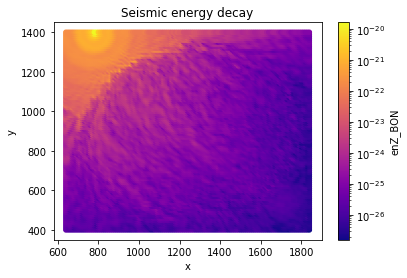

In [6]:
fig = plt.figure()
ax  = fig.add_subplot(111)
im  = data.plot.scatter(x='x', 
                        y='y', 
                        c='enZ_BON', 
                        cmap='plasma',
                        norm=colors.LogNorm(vmin=data.enZ_BON.min(),
                                            vmax=data.enZ_BON.max()),
                        ax=ax)
title = ax.set_title('Seismic energy decay')

Absolute values are hard to compare with the field observations.  
This is because the rockfall source is a big unknown!

It becomes more interesting when looking at *inter-station energy ratios*:

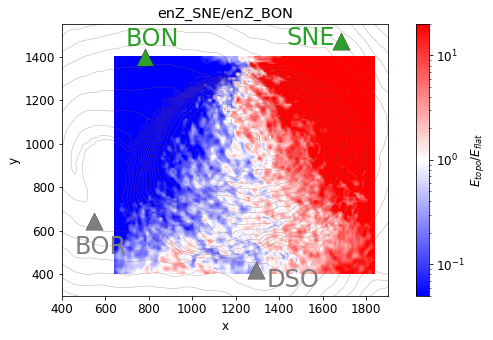

In [7]:
ref_station = 'enZ_BON'
sec_station = 'enZ_SNE'

plot_ratios_on_map(data, ref_station, sec_station)

Here, the **influence of the surface topography** can be nicely observed!  
Not considering the topography, we would have something like this:

![Flat model](images/ratios_flat.png)


*We built the synthetic database - now we are ready to localize real rockfalls!*

## Rockfall localization routine

### Define Parameters
You can select the following values for each parameter:

| Parameter     | Value       | Function  |
| ------------- |-------------| ----------|
| *event*   | '2016.348', '2017.022'| Choose between 2 rockfalls |
| *chID*    | 'Z', 'ENZ'            | Only vertical or 3 components |
| *site_eff_deconv* | True, False | Site effect correction of signals |
| *lwin*  | float | Length (seconds) of sliding time window |
| *swin*  | float | Step size (seconds) of sliding time window |
| *freqband* | [fmin, fmax] | Corner values (Hertz) of frequency band which is used for localization  |


In [8]:
# Event selection:
event   = '2016.348'

# Parameters which we can tune:
chID    = 'ENZ'
site_eff_deconv = True 

lwin = 4.
swin = 2.

# Here we only look at one frequency band:
freqband = [13., 17.]

# Grid dimensions
xdim = 121
ydim = 101

# Determine closest station according to event:
if   event == '2016.348':
    nearSTA = 'BOR'
elif event == '2017.022':
    nearSTA = 'BON'
else:
    print("Please select event '2016.348' or '2017.022'")

### Load rockfall signals
The rockfall seismic signals are loaded using `ObsPy`. All signals are stored as *Traces* in a *Stream*.

In [9]:
# Create Stream with all signals
st = Stream()
if   chID == 'ENZ':
        channels = [ 'Z','N','E']
elif chID == 'Z':
        channels = [ 'Z']
path_event = 'data/signals/'+event+'/'
for ch in channels:
    st += read(path_event+"/PF.*"+ch+".D.20*.VEL")
st.sort()    
    
# Pre-filter the signal:
st.filter('bandpass', freqmin=1., freqmax=40.,
                    corners = 2, zerophase = 'true')
# Determine starttime t0
t0 = st[0].stats.starttime
eventDate = (str(t0.year)+'-'+str(t0.month).zfill(2)+'-'+
             str(t0.day).zfill(2)+'  '+str(t0.hour).zfill(2)+':'+
             str(t0.minute).zfill(2)+':'+str(t0.second).zfill(2))
print(st)

10 Trace(s) in Stream:
PF.BON.00.HHE | 2016-12-13T11:08:45.000000Z - 2016-12-13T11:10:45.000000Z | 100.0 Hz, 12001 samples
PF.BON.00.HHN | 2016-12-13T11:08:45.000000Z - 2016-12-13T11:10:45.000000Z | 100.0 Hz, 12001 samples
PF.BON.00.HHZ | 2016-12-13T11:08:45.000000Z - 2016-12-13T11:10:45.000000Z | 100.0 Hz, 12001 samples
PF.BOR.00.EHE | 2016-12-13T11:08:45.003130Z - 2016-12-13T11:10:45.003130Z | 100.0 Hz, 12001 samples
PF.BOR.00.EHN | 2016-12-13T11:08:45.003130Z - 2016-12-13T11:10:45.003130Z | 100.0 Hz, 12001 samples
PF.BOR.00.EHZ | 2016-12-13T11:08:45.003131Z - 2016-12-13T11:10:45.003131Z | 100.0 Hz, 12001 samples
PF.DSO.90.EHZ | 2016-12-13T11:08:45.003130Z - 2016-12-13T11:10:45.003130Z | 100.0 Hz, 12001 samples
PF.SNE.00.HHE | 2016-12-13T11:08:44.998393Z - 2016-12-13T11:10:44.998393Z | 100.0 Hz, 12001 samples
PF.SNE.00.HHN | 2016-12-13T11:08:44.998393Z - 2016-12-13T11:10:44.998393Z | 100.0 Hz, 12001 samples
PF.SNE.00.HHZ | 2016-12-13T11:08:44.998393Z - 2016-12-13T11:10:44.998393Z | 1

Let's have a first look on the rockfall signals!

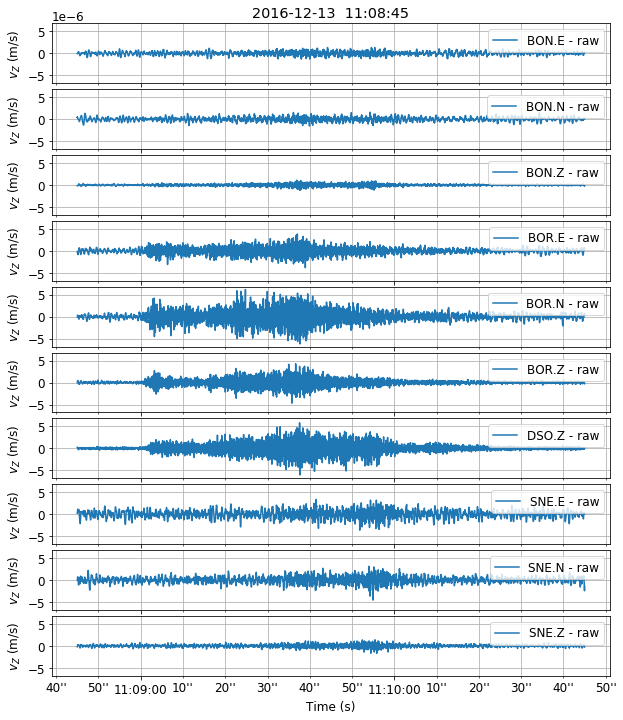

In [10]:
plot_traces([st],['raw'],eventDate)

### Processing the signals
The signal at a station can be **amplified due to the local soil structure**.  
This can bias the localization when the stations are differently influenced.  

In order to avoid this bias, the site effects are removed by deconvolution with spectral site amplification functions which we estimated using seismic signals of volcano-tectonic (VT) events, stored in `data/site_effects/`.

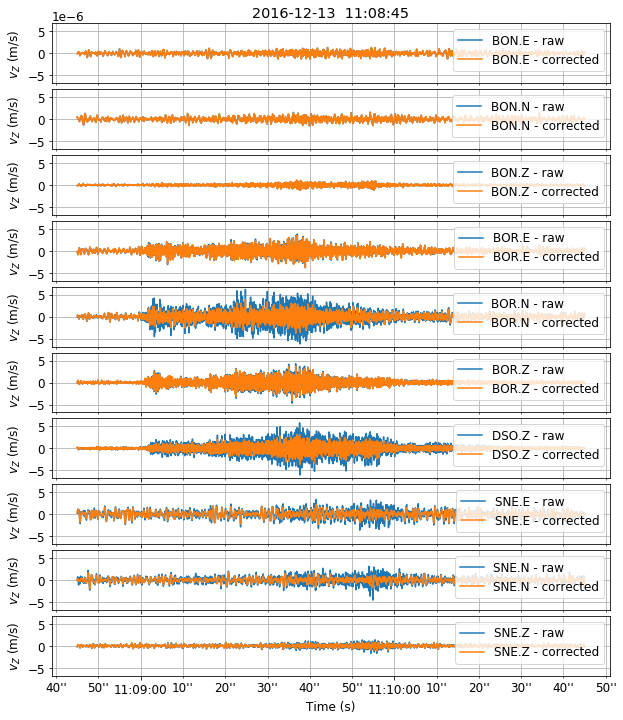

In [11]:
# Site effect deconvolution
if site_eff_deconv:
    st_raw = st.copy()
    # We remove the site effects from each trace tr:
    for tr in st:
        tr = deconvolve_SE(tr)
    # Plotting the site corrected signals
    plot_traces([st_raw,st],['raw','corrected'],eventDate)

Now the singals are band-pass filtered in the frequency band in which observed and simulated energy ratios will be compared:

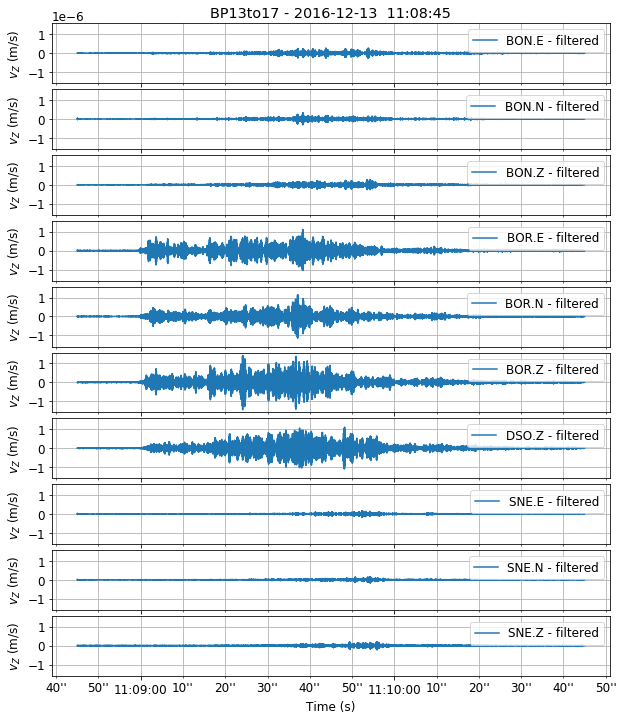

In [12]:
# Band-pass filtering the signals
freqmin = freqband[0]
freqmax = freqband[1]
freqID  = 'BP'+str(int(freqmin))+'to'+str(int(freqmax))
st.filter('bandpass', freqmin=freqmin, freqmax=freqmax,
                    corners = 2, zerophase = 'true')
plot_traces([st],['filtered'],freqID+' - '+eventDate)

### Pick start and end time of rockfall signal
In this example, we *interactively* pick the time window of the rockfall. 

In a real application, the detection, classification and time picking of rockfall signals can be realised *automatically* using machine learning techniques [5][6].

File with picked time window already exists.


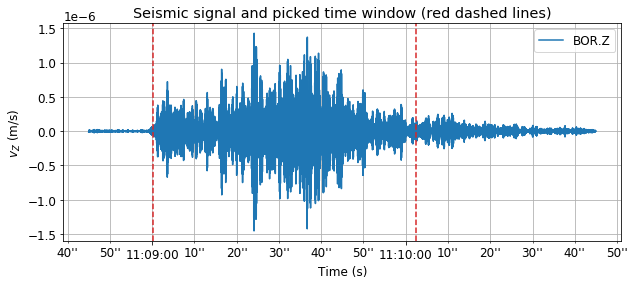

In [13]:
if os.path.isfile('pickedTW_'+event+'.txt'):
    newPick = False
    print('File with picked time window already exists.')
    plot_trace(st.select(station=nearSTA,channel='*Z')[0],event)
else:
    # Activate interactive plotting:
    %matplotlib notebook
    %matplotlib notebook  
    import matplotlib.pyplot as plt
    newPick = True
    pickTW(st.select(station=nearSTA,channel='*Z')[0])

Loading the picked start and end time:

In [14]:
# Only in case of newly picked time window
if newPick:
    # Rename file with picked time window according to event:
    os.rename('pickedTW.txt', 'pickedTW_'+event+'.txt')
    # Deactivate interactive plotting:
    %matplotlib inline
    %matplotlib inline  
    import matplotlib.pyplot as plt

# Load time window
pickedTW = np.loadtxt('pickedTW_'+event+'.txt')
tstart = UTCDateTime(num2date(pickedTW[0]))
tend   = UTCDateTime(num2date(pickedTW[1]))

# Define start of time window relative to signal starttime 
offset  = (tstart+swin-lwin/2) - t0
n_TWs   = int((tend-tstart)/swin)

### Optimization method for source localization
Using a sliding window, he rockfall signal is analyzed over its whole duration.

In each time step, a misfit $e_{\mathrm{tw}}$ is calculated at each grid position between observed energy ratios $E^{\mathrm{obs}}_{ij,\mathrm{tw}}$ and simulations $E^{\mathrm{simu}}_{ij}$:

$$e_{\mathrm{tw}} = \frac{1}{N_{\mathrm{Sta}}} \sum_{ij}^{N_{\mathrm{Sta}}} 
	\left| \log_{10} 
	\left( \frac{E^{\mathrm{simu}}_{ij}}{E^{\mathrm{simu}}_{\mathrm{ref},j}} \div
	\frac{E^{\mathrm{obs}}_{ij,\mathrm{tw}}}{E^{\mathrm{obs}}_{\mathrm{ref},j,\mathrm{tw}}} \right)
	\right|$$

To go one step further and evaluate the rockfall trajectory over the whole duration, we determine at each grid position the smallest mistfit and its corresponding time:
    
$$e = \min_{\mathrm{tw}} e_{\mathrm{tw}}$$

In [15]:
# Pre-allocate arrays of probabilities and corresponding times
probs = np.zeros((ydim,xdim))
times = np.zeros((ydim,xdim))

slider = tqdm(enumerate(st.slide(window_length=lwin, 
                                 step=swin,
                                 offset=offset,
                                 include_partial_windows=True)),
              total=n_TWs)

for iTW, windowed_st in slider:
    
    slider.set_description("Sliding TW=%s" % iTW)
    
    # Condition to stop analysis at the end of the time window
    if (windowed_st[0].stats.starttime+lwin/2) > tend:
        break
    
    # Algorithm which compares observed energy ratios with 
    # synthetic energy ratios from each potential source position
    probs_tw = calc_prob(windowed_st, channels, ydim, xdim, freqID)
    
    # Find highest probability across the whole signal duration
    # and store probability value and corresponding time
    if iTW == 0:
        t_rel = 0.
        times[:,:] = t_rel
        probs = probs_tw
    else:
        t_rel += swin
        for ii in range(ydim):
            for jj in range(xdim):
                if probs[ii,jj] < probs_tw[ii,jj]:
                    times[ii,jj] = t_rel
                    probs[ii,jj] = probs_tw[ii,jj]

Sliding TW=31: 100%|██████████| 31/31 [00:21<00:00,  1.46it/s]


### Result Visualization
Using a 2D colormap, we can visualize in a static image both 
* source location probability (*saturation*), and
* correspinding time (*color*). 

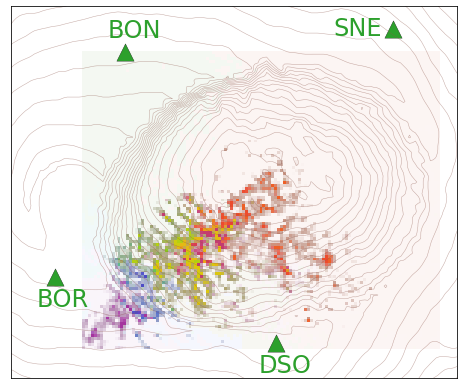

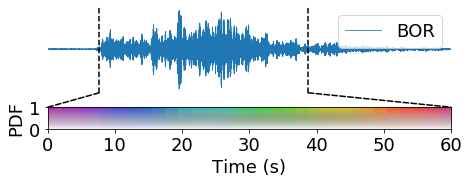

In [25]:
# Define array of size (2, nx, ny) which contains maps of 
# times and probabilities. 
loc_prob_time   = np.array([ np.flipud(times), 
                             np.flipud(probs)/10. ])

# Plot the spatio-temporal rockfall location probability.
plot_LOCA(loc_prob_time, t_rel, swin)
# Plot colorbar and trace to visualize the time window used for 
# the localization.
plot_Tr_Cb(st.select(station=nearSTA,channel='*Z')[0], 
           pickedTW[0], pickedTW[1], t_rel, swin)

## Conclusions

We just located a real rockfall on Réunion island based on generated seismic signals :)

* Rockfall trajectory can be followed over time


* Sliding time window allows real-time monitoring


* Detection and processing steps can be automatised


* One database for all events in sampled area

**References:**  

[1] **Kuehnert, J.**, Mangeney, A., Capdeville, Y., Vilotte, J. P., Stutzmann, E., Chaljub, E., ... & Lauret, F. (2020). *Rockfall localization based on inter-station ratios of seismic energy.* doi:10.1002/essoar.10503303.1

[2] **Kuehnert, J.**, Mangeney, A., Capdeville, Y., Métaxian, J.-P., Bonilla, L. F., Stutzmann, E., . . .  Hibert, C.(2020). *Simulation of rockfall generated seismic signals and the influence of surface topography.* doi:10.1002/ESSOAR.10502632. 

[3] Komatitsch, D., & Vilotte, J.-P.  (1998).  *The Spectral Element Method:  An EfficientTool to Simulate the Seismic Response of 2D and 3D Geological Structures.* Bulletin of the Seismological Society of America, 88(2), 368–392

[4] Chaljub, E., Komatitsch, D., Vilotte, J. P., Capdeville, Y., Valette, B., & Festa,G. (2007). *Spectral-element analysis in seismology.* Advances in Geophysics, 48(06), 365–419. doi:10.1016/S0065-2687(06)48007-9

[5] Provost, F., Hibert, C., and Malet, J.-P. (2017). *Automatic classification of endogenous landslide seismicity using the Random Forest supervised classifier.* Geophysical Research Letters, 44(1):113–120.

[6] Hibert, C., Provost, F., Malet, J. P., Maggi, A., Stumpf, A., and Ferrazzini, V. (2017c). *Automatic identification of rockfalls and volcano-tectonic earthquakes at the Piton de la Fournaise volcano using a Random Forest algorithm.* Journal of Volcanology and Geothermal Research, 340:130–142.